In [ ]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-nfn/data_fold0.zip

replace data_fold0/labels/val/2718854859_2308494170_14.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
ls

data_fold0/  spine_detection/  state.db  yolo11n.pt  yolo_scs.yaml


In [4]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [5]:
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64

SAMPLE = None
CONDITIONS = ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'



In [6]:
# rm -rf val_fold0

In [7]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [8]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [9]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [10]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [11]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)
#     raise ValueError('Condition not found '+ lev)

In [12]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [13]:
# train_df = train_df.dropna()

In [14]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [15]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [16]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [17]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [18]:
# label_df[['study_id', 'series_id']].drop_duplicates()

In [19]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

In [20]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [21]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [22]:
id2label

{0: 'left_neural_foraminal_narrowing_l1_l2_normal/mild',
 1: 'left_neural_foraminal_narrowing_l1_l2_moderate',
 2: 'left_neural_foraminal_narrowing_l1_l2_severe',
 3: 'left_neural_foraminal_narrowing_l2_l3_normal/mild',
 4: 'left_neural_foraminal_narrowing_l2_l3_moderate',
 5: 'left_neural_foraminal_narrowing_l2_l3_severe',
 6: 'left_neural_foraminal_narrowing_l3_l4_normal/mild',
 7: 'left_neural_foraminal_narrowing_l3_l4_moderate',
 8: 'left_neural_foraminal_narrowing_l3_l4_severe',
 9: 'left_neural_foraminal_narrowing_l4_l5_normal/mild',
 10: 'left_neural_foraminal_narrowing_l4_l5_moderate',
 11: 'left_neural_foraminal_narrowing_l4_l5_severe',
 12: 'left_neural_foraminal_narrowing_l5_s1_normal/mild',
 13: 'left_neural_foraminal_narrowing_l5_s1_moderate',
 14: 'left_neural_foraminal_narrowing_l5_s1_severe',
 15: 'right_neural_foraminal_narrowing_l1_l2_normal/mild',
 16: 'right_neural_foraminal_narrowing_l1_l2_moderate',
 17: 'right_neural_foraminal_narrowing_l1_l2_severe',
 18: 'right

In [23]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

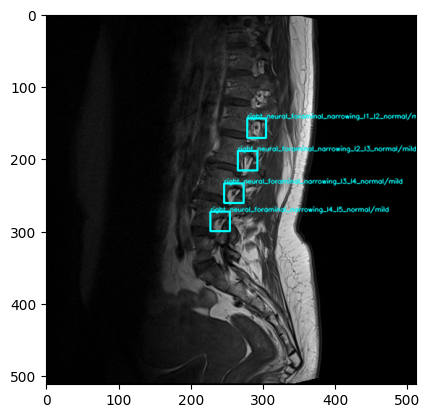

In [24]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)
fontFace = cv2.FONT_HERSHEY_SIMPLEX

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [25]:
# ls data_fold0/labels/val

In [26]:
# os.path.join(_ANN_DIR, name+'.txt')

In [27]:
# cat 'train_fold0/labels/404602713_1230697721_12.txt'

In [28]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-jkq3qpos
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-jkq3qpos
  Resolved https://github.com/ultralytics/ultralytics.git to commit 4453ddab93c390c11c9f8bb8d90a761a4cec3342
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.31-py3-none-any.whl size=886316 sha256=a41bce360a3a530997e0423757fd28b01788ec08bb7c7edc9811c7a50e0516bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-iux346i2/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics


In [29]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: left_neural_foraminal_narrowing_l1_l2_normal/mild
1: left_neural_foraminal_narrowing_l1_l2_moderate
2: left_neural_foraminal_narrowing_l1_l2_severe
3: left_neural_foraminal_narrowing_l2_l3_normal/mild
4: left_neural_foraminal_narrowing_l2_l3_moderate
5: left_neural_foraminal_narrowing_l2_l3_severe
6: left_neural_foraminal_narrowing_l3_l4_normal/mild
7: left_neural_foraminal_narrowing_l3_l4_moderate
8: left_neural_foraminal_narrowing_l3_l4_severe
9: left_neural_foraminal_narrowing_l4_l5_normal/mild
10: left_neural_foraminal_narrowing_l4_l5_moderate
11: left_neural_foraminal_narrowing_l4_l5_severe
12: left_neural_foraminal_narrowing_l5_s1_normal/mild
13: left_neural_foraminal_narrowing_l5_s1_moderate
14: left_neural_foraminal_narrowing_l5_s1_severe
15: right_neural_foraminal_narrowing_l1_l2_normal/mild
16: right_neural_foraminal_narrowing_l1_l2_moderate
17: right_neural_foraminal_narrowing_l1_l2_severe
18: right_neural_foraminal_narrowing_l2_l3_normal/mild
19: right_neural_foraminal_n

In [30]:
ls

data_fold0/  spine_detection/  state.db  yolo11n.pt  yolo_scs.yaml


In [31]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: left_neural_foraminal_narrowing_l1_l2_normal/mild
    1: left_neural_foraminal_narrowing_l1_l2_moderate
    2: left_neural_foraminal_narrowing_l1_l2_severe
    3: left_neural_foraminal_narrowing_l2_l3_normal/mild
    4: left_neural_foraminal_narrowing_l2_l3_moderate
    5: left_neural_foraminal_narrowing_l2_l3_severe
    6: left_neural_foraminal_narrowing_l3_l4_normal/mild
    7: left_neural_foraminal_narrowing_l3_l4_moderate
    8: left_neural_foraminal_narrowing_l3_l4_severe
    9: left_neural_foraminal_narrowing_l4_l5_normal/mild
    10: left_neural_foraminal_narrowing_l4_l5_moderate
    11: left_neural_foraminal_narrowing_l4_l5_severe
    12: left_neural_foraminal_narrowing_l5_s1_normal/mild
    13: left_neural_foraminal_narrowing_l5_s1_moderate
    14: left_neural_foraminal_narrowing_l5_s1_severe
    15: right_neural_foraminal_narrowing_l1_l2_normal/mild
    16: right_neural_foraminal_narrowing_l1_l2_moderate
    17: right_neural_foraminal_narrowing_l1_l2_severe
    18: right_neural_foraminal_narrowing_l2_l3_normal/mild
    19: right_neural_foraminal_narrowing_l2_l3_moderate
    20: right_neural_foraminal_narrowing_l2_l3_severe
    21: right_neural_foraminal_narrowing_l3_l4_normal/mild
    22: right_neural_foraminal_narrowing_l3_l4_moderate
    23: right_neural_foraminal_narrowing_l3_l4_severe
    24: right_neural_foraminal_narrowing_l4_l5_normal/mild
    25: right_neural_foraminal_narrowing_l4_l5_moderate
    26: right_neural_foraminal_narrowing_l4_l5_severe
    27: right_neural_foraminal_narrowing_l5_s1_normal/mild
    28: right_neural_foraminal_narrowing_l5_s1_moderate
    29: right_neural_foraminal_narrowing_l5_s1_severe

Overwriting yolo_scs.yaml


In [32]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO('/kaggle/input/yolov11x/other/default/1/yolo11x.pt')
            
config = {
    'data': "/kaggle/working/yolo_scs.yaml",
    'imgsz': 384,
    'batch': 16,
    'epochs': 100,
    'patience': 15,
    'device': '0,1',
    'workers': 8,
    'project': 'spine_detection',
    'name': 'Neural_Foraminal_Narrowing_yolo',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'verbose': True,
    'seed': 42,
    'deterministic': True,
    'dropout': 0.2,
    'lr0': 0.001,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 10,
    'warmup_momentum': 0.8,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'close_mosaic': 10,
    'amp': True,
}

results = model.train(**config)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/yolov11x/other/default/1/yolo11x.pt, data=/kaggle/working/yolo_scs.yaml, epochs=100, time=None, patience=15, batch=16, imgsz=384, save=True, save_period=-1, cache=False, device=0,1, workers=8, project=spine_detection, name=Neural_Foraminal_Narrowing_yolo, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, 

100%|██████████| 755k/755k [00:00<00:00, 11.9MB/s]
2024-11-15 10:15:57,581	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-15 10:15:58,382	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytic

train: Scanning /kaggle/working/data_fold0/labels/train.cache... 6621 images, 15 backgrounds, 0 corrupt: 100%|██████████| 6621/6621 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val.cache... 1661 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1661/1661 [00:00<?, ?it/s]


Plotting labels to spine_detection/Neural_Foraminal_Narrowing_yolo/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to spine_detection/Neural_Foraminal_Narrowing_yolo
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.66G      2.093      2.723      1.031         34        384: 100%|██████████| 414/414 [02:27<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:23<00:00,  4.35it/s]


                   all       1661       3950      0.304      0.279      0.127     0.0492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       4.6G      1.925      2.197      0.989         36        384: 100%|██████████| 414/414 [02:19<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.292      0.354      0.159     0.0653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.62G      1.845      2.103     0.9695         27        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.64it/s]


                   all       1661       3950      0.444      0.308      0.166     0.0667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.62G      1.834      2.089     0.9634         25        384: 100%|██████████| 414/414 [02:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.64it/s]


                   all       1661       3950      0.326      0.369      0.184     0.0823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.62G      1.815      2.066     0.9593         14        384: 100%|██████████| 414/414 [02:09<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.71it/s]


                   all       1661       3950      0.326      0.369      0.184     0.0823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.62G      1.758      1.976     0.9479         28        384: 100%|██████████| 414/414 [02:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.353      0.431      0.211     0.0915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.61G      1.749      1.959     0.9444         31        384: 100%|██████████| 414/414 [02:03<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.337       0.39      0.193     0.0833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.61G      1.716       1.97     0.9384         26        384: 100%|██████████| 414/414 [02:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.352      0.457      0.236      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.61G      1.699      1.923     0.9348         15        384: 100%|██████████| 414/414 [02:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.70it/s]


                   all       1661       3950      0.296      0.431      0.223      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.61G      1.697      1.889     0.9353         38        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950       0.31      0.471      0.228      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.67G      1.658      1.898     0.9306         29        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


                   all       1661       3950      0.239      0.523       0.24      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.61G      1.641      1.867     0.9242         14        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.245      0.479      0.235      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.67G      1.643      1.831     0.9253         25        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.314      0.479      0.239      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.61G      1.634      1.826      0.924         18        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.70it/s]


                   all       1661       3950      0.218      0.549      0.237      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.67G      1.611      1.781     0.9205         28        384: 100%|██████████| 414/414 [02:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.316      0.508      0.252      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.61G       1.62      1.785     0.9253         17        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.279      0.468      0.236      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.66G      1.602      1.793     0.9177         27        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.218      0.527       0.25      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.61G      1.602      1.783     0.9155         15        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.252      0.497       0.25      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.67G      1.585      1.777     0.9156         19        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.322      0.505      0.259      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.61G      1.574      1.764      0.911         18        384: 100%|██████████| 414/414 [02:02<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950       0.27      0.472      0.246       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.66G      1.584      1.761     0.9187         23        384: 100%|██████████| 414/414 [02:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.294      0.513      0.252      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.61G       1.59      1.769     0.9153         30        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.235      0.501      0.256      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.66G      1.562      1.746     0.9131         31        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.297      0.519      0.261       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.61G      1.542      1.735     0.9129         19        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.275      0.518      0.264      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.67G      1.565      1.735     0.9095         30        384: 100%|██████████| 414/414 [02:02<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.63it/s]


                   all       1661       3950      0.297      0.512       0.26      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.61G      1.551      1.703       0.91         27        384: 100%|██████████| 414/414 [02:02<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.278      0.503      0.282      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.67G      1.535      1.712     0.9057         23        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.223      0.501      0.272      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.61G      1.542      1.715     0.9091         37        384: 100%|██████████| 414/414 [02:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.247      0.519      0.291      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.67G      1.528      1.687     0.9023         31        384: 100%|██████████| 414/414 [02:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.285      0.491      0.304      0.157

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.61G      1.531      1.674     0.9027         27        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.64it/s]


                   all       1661       3950      0.362      0.529      0.332      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.67G      1.524      1.638     0.9054         17        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.416       0.51      0.372      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.61G       1.52      1.626     0.9024         41        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.456      0.518      0.397      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.66G      1.524      1.581     0.9072         34        384: 100%|██████████| 414/414 [02:02<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.453      0.507      0.417      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.61G      1.531      1.538     0.9091         12        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.417      0.543      0.446      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.67G      1.516      1.517     0.9035         51        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


                   all       1661       3950      0.458      0.554      0.458      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.61G      1.509      1.478     0.9039         31        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.429      0.538      0.459      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.66G      1.518      1.468     0.9056         16        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950       0.44      0.531      0.474      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.61G      1.518      1.439     0.9007         26        384: 100%|██████████| 414/414 [02:01<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.459      0.572      0.463      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.67G       1.52      1.435     0.9063         19        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.70it/s]


                   all       1661       3950      0.451      0.557       0.49       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.61G      1.506      1.425     0.9002         28        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.478      0.588      0.485      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.67G      1.504      1.406     0.9017         26        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.70it/s]


                   all       1661       3950      0.435      0.533      0.482       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.61G      1.483      1.385     0.8973         18        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.461      0.533      0.485      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.67G      1.501      1.393     0.9003         21        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


                   all       1661       3950      0.452      0.542      0.484      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.61G      1.485      1.387     0.8997         39        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.442       0.57      0.487      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.66G      1.495      1.391     0.8996         18        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950        0.4      0.556      0.468      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.61G      1.507      1.387      0.905         20        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.435      0.566       0.48      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.67G      1.484      1.376     0.8992         17        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.418      0.574      0.483      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.61G      1.461      1.382     0.8935         20        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.459      0.536      0.495      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.66G      1.463      1.358     0.8957         14        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


                   all       1661       3950      0.475      0.562      0.487      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.61G      1.474      1.352     0.8964         14        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.421      0.587      0.482      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.66G      1.472      1.338     0.8956         24        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950       0.45      0.562      0.497       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.61G      1.472      1.325     0.8966         14        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


                   all       1661       3950      0.456      0.556      0.494      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.66G       1.47       1.33     0.8943         17        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.70it/s]


                   all       1661       3950      0.435      0.561      0.494      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.61G       1.47      1.354     0.8948         26        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.436      0.573      0.492      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.67G      1.463      1.311     0.8978         19        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.66it/s]


                   all       1661       3950      0.478      0.529      0.501      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.61G      1.462      1.317     0.8958         15        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950      0.446      0.562      0.486      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.67G       1.45      1.303     0.8942         20        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.452      0.573      0.501      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.61G      1.459      1.315     0.8974         41        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.70it/s]


                   all       1661       3950      0.489      0.554      0.496      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.67G      1.448       1.28     0.8959         23        384: 100%|██████████| 414/414 [02:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950       0.45      0.557      0.497      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       4.6G      1.433      1.284     0.8903         26        384: 100%|██████████| 414/414 [02:01<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.71it/s]


                   all       1661       3950      0.453      0.568      0.495      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.67G      1.445      1.283     0.8952         16        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.449      0.573      0.492      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.61G      1.452      1.298     0.8923         27        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.458      0.543      0.491       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.66G      1.448      1.293     0.8934         14        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.69it/s]


                   all       1661       3950       0.45      0.542      0.487      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.61G      1.446      1.268      0.893         18        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


                   all       1661       3950      0.464      0.572      0.489      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.67G      1.449      1.277     0.8932         18        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.436      0.558      0.483      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.61G      1.447      1.259     0.8905         26        384: 100%|██████████| 414/414 [02:01<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950       0.44      0.575       0.49      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.67G      1.441      1.272     0.8941         29        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.461      0.555      0.491      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.61G       1.43      1.263     0.8913         26        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.67it/s]


                   all       1661       3950      0.449      0.566      0.494      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.67G       1.44      1.252     0.8943         17        384: 100%|██████████| 414/414 [02:02<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.65it/s]


                   all       1661       3950      0.488      0.548      0.493      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.61G      1.425      1.263     0.8893         21        384: 100%|██████████| 414/414 [02:02<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:22<00:00,  4.68it/s]


                   all       1661       3950      0.444      0.542      0.485      0.257
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 55, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

70 epochs completed in 2.873 hours.
Optimizer stripped from spine_detection/Neural_Foraminal_Narrowing_yolo/weights/last.pt, 114.4MB
Optimizer stripped from spine_detection/Neural_Foraminal_Narrowing_yolo/weights/best.pt, 114.4MB

Validating spine_detection/Neural_Foraminal_Narrowing_yolo/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
YOLO11x summary (fused): 464 layers, 56,861,674 parameters, 0 gradients, 194.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 104/104 [00:24<00:00,  4.22it/s]


                   all       1661       3950      0.478      0.529      0.499       0.26
left_neural_foraminal_narrowing_l1_l2_normal/mild        380        380      0.643      0.837      0.775      0.375
left_neural_foraminal_narrowing_l1_l2_moderate         15         15      0.621      0.221      0.431      0.257
left_neural_foraminal_narrowing_l2_l3_normal/mild        358        358       0.65      0.807      0.721      0.387
left_neural_foraminal_narrowing_l2_l3_moderate         34         34      0.533      0.412      0.427      0.202
left_neural_foraminal_narrowing_l2_l3_severe          3          3          0          0      0.125     0.0444
left_neural_foraminal_narrowing_l3_l4_normal/mild        305        305       0.63      0.823      0.742      0.401
left_neural_foraminal_narrowing_l3_l4_moderate         83         83      0.342      0.375      0.343      0.186
left_neural_foraminal_narrowing_l3_l4_severe          7          7      0.537      0.571      0.537      0.243
le

right_neural_foraminal_narrowing_l4_l5_moderate
right_neural_foraminal_narrowing_l5_s1_normal/mild


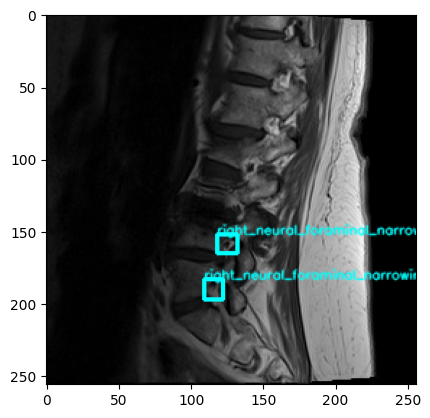

In [33]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [36]:
# Initialize YOLO Model
model = YOLO(glob.glob("/kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/weights/best.pt")[0])

out = model.predict([path], save=True, conf=0.2)




0: 384x384 1 right_neural_foraminal_narrowing_l1_l2_normal/mild, 1 right_neural_foraminal_narrowing_l2_l3_normal/mild, 1 right_neural_foraminal_narrowing_l4_l5_normal/mild, 42.9ms
Speed: 1.7ms preprocess, 42.9ms inference, 64.1ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


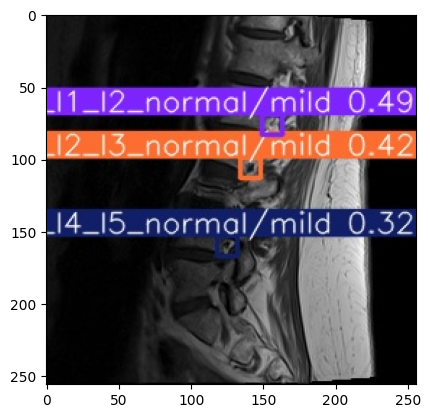

In [37]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)

In [38]:
!zip -r /kaggle/working/Neural_Foraminal_Narrowing_yolo.zip /kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/ (stored 0%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/val_batch0_pred.jpg (deflated 10%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/confusion_matrix_normalized.png (deflated 16%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/train_batch2.jpg (deflated 10%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/val_batch2_labels.jpg (deflated 11%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/train_batch0.jpg (deflated 8%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/results.csv (deflated 61%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/val_batch2_pred.jpg (deflated 11%)
  adding: kaggle/working/spine_detection/Neural_Foraminal_Narrowing_yolo/confusion_matrix.png (deflated 16%)
  adding: kaggle/working/spine_detection/Neural_Fo